In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scripts.market_api import get_yfinance_time_series, get_fred_time_series
from matplotlib.ticker import NullFormatter

In [2]:
def plot_fundings(data):
    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(lambda x, pos: x / 1e9)
    sns.barplot(x='announced_on', y='raised_amount_usd', data=data, palette='winter', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_xlabel('')
    ax.set_ylabel('Capital raised ($B)')

    y = data.raised_amount_usd
    for i, v in enumerate(y):
        ax.text(x=i-0.20, y=v/y.iloc[i] + min(y)/2.5,
                s=int(y.iloc[i] / 1e9),
                rotation=90, fontsize=12, weight='regular')
    plt.show()

In [3]:
rounds = pd.read_csv('../../data/crunchbase/funding_rounds.csv')
rounds.announced_on = pd.to_datetime(rounds.announced_on, errors='coerce')
rounds['year'] = rounds.announced_on.dt.year

FileNotFoundError: [Errno 2] No such file or directory: '../../data/crunchbase/funding_rounds.csv'

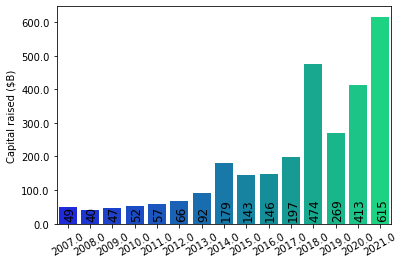

In [ ]:
start = 2007
end = 2021

fundings_per_year_US = rounds[(rounds.announced_on.dt.year >= start)
                              & (rounds.announced_on.dt.year <= end)
                              & (rounds.country_code == "USA")]
fundings_per_year_US = fundings_per_year_US[['announced_on', 'raised_amount_usd']]
fundings_per_year_US = fundings_per_year_US.groupby(rounds.announced_on.dt.year).sum().reset_index()

plot_fundings(fundings_per_year_US)

In [ ]:
orgs = pd.read_csv('../../data/crunchbase/organizations.csv')

In [ ]:
cats = orgs[orgs.uuid.isin(rounds.org_uuid)][['uuid', 'category_groups_list']].dropna()
cats.category_groups_list = cats.category_groups_list.apply(lambda x: x.split(','))
cats.columns = ['org_uuid', 'category']

In [ ]:
stages = {
    'early stage': ['angel', 'seed', 'pre_seed', 'product_crowdfunding', 'equity_crowdfunding', 'initial_coin_offering', 'non_equity_assistance'],
    'mid stage': ['series_a', 'series_b', 'corporate_round'],
    'late stage': ['series_c', 'series_d', 'series_e', 'series_f', 'series_i', 'series_g', 'series_h', 'series_j'],
    'other': ['post_ipo_equity', 'post_ipo_secondary', 'post_ipo_debt', 'series_unknown', 'undisclosed', 'debt_financing', 'grant', 'convertible_note', 'secondary_market']
}

stage_map = {}
for k, v in stages.items():
    for x in v:
        stage_map[x] = k

rounds['stage'] = rounds.investment_type.map(stage_map)

In [ ]:
print(rounds[rounds.investment_type == 'series_b'][['raised_amount_usd', 'post_money_valuation_usd']].dropna().median())
print(rounds[rounds.investment_type == 'series_c'][['raised_amount_usd', 'post_money_valuation_usd']].dropna().median())
print(rounds[rounds.investment_type == 'corporate_round'][['raised_amount_usd', 'post_money_valuation_usd']].dropna().median())

raised_amount_usd           $31,106,019.50
post_money_valuation_usd   $200,000,000.00
dtype: float64
raised_amount_usd           $80,000,000.00
post_money_valuation_usd   $650,000,000.00
dtype: float64
raised_amount_usd           $35,801,590.50
post_money_valuation_usd   $291,768,304.50
dtype: float64


In [ ]:
start = 2007
end = 2021

fundings_per_year_stage = rounds[(rounds.announced_on.dt.year >= start)
                                 & (rounds.announced_on.dt.year <= end)
                                 & (rounds.country_code == "USA")]
fundings_per_year_stage = fundings_per_year_stage[['year', 'raised_amount_usd', 'stage']].dropna()
fundings_per_year_stage = fundings_per_year_stage.groupby(['year', 'stage']).sum().reset_index()
fundings_per_year_stage = fundings_per_year_stage[fundings_per_year_stage.stage != 'other']
fundings_per_year_stage.year = fundings_per_year_stage.year.astype(int)

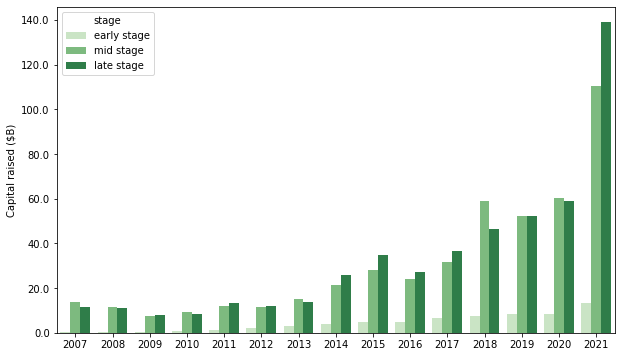

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.yaxis.set_major_formatter(lambda x, pos: x / 1e9)
sns.barplot(x="year", y="raised_amount_usd", hue="stage", hue_order=['early stage', 'mid stage', 'late stage'], data=fundings_per_year_stage, ax=ax, palette='Greens')
ax.set_xlabel('')
ax.set_ylabel('Capital raised ($B)')
# sns.set(font_scale = 1.2)
plt.savefig('figures/capital_raised.pdf')
plt.show()

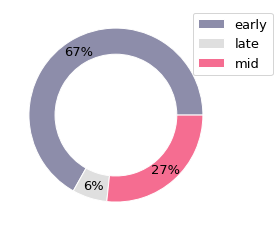

In [ ]:
plt.pie(rounds.groupby('stage').size().drop('other'),
        radius=1, wedgeprops=dict(width=0.3, edgecolor='w'), textprops={'fontsize':13},
        colors=['#8D8DAA', '#DFDFDF', '#F56D91'], autopct='%.0f%%', pctdistance=0.85)
plt.legend(['early', 'late', 'mid'], bbox_to_anchor=(0.75, 0, 0.5, 1), fontsize=13)
plt.savefig('figures/total_rounds_per_stage.pdf')

In [ ]:
rounds.groupby('stage').size()

stage
early stage    210962
late stage      20423
mid stage       84197
other          157774
dtype: int64

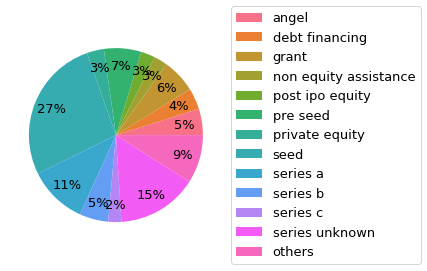

In [ ]:
cb_investments = rounds.groupby('investment_type').size() / rounds.shape[0]
cb_investments['others'] = cb_investments[cb_investments < 0.02].sum()
cb_investments = cb_investments[cb_investments >= 0.02]
cb_investments.index = pd.Series(cb_investments.index).apply(lambda s: s.replace('_', ' '))
plt.pie(cb_investments, autopct='%.0f%%', pctdistance=0.8, colors=sns.color_palette("husl", cb_investments.size), textprops={'fontsize':13},)
plt.legend(cb_investments.index, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=13)
plt.savefig('figures/crunchbase_rounds.pdf')
plt.show()

In [ ]:
from tqdm import tqdm
tqdm.pandas()

def get_most_relevant_cat(categories):
    mapped = cat_freqs[cat_freqs.index.isin(categories)]
    return categories[np.argmax(mapped)]

summarized_cats = ['Media',
                   'Software',
                   'IT Hardware',
                   'Consumer P&S',
                   'Consumer P&S',
                   'Media',
                   'Software',
                   'Software',
                   'Media',
                   'Software',
                   'Consumer P&S',
                   'Other',
                   'Commercial P&S',
                   'Software',
                   'Media',
                   'IT Hardware',
                   'Other',
                   'Other',
                   'Commercial P&S',
                   'Commercial P&S',
                   'Biotech',
                   'Other',
                   'Healthcare',
                   'Other',
                   'Consumer P&S',
                   'Consumer P&S',
                   'Software',
                   'Software',
                   'Consumer P&S',
                   'IT Hardware',
                   'Software',
                   'Other',
                   'Commercial P&S',
                   'Commercial P&S',
                   'Other',
                   'Energy',
                   'Other',
                   'Commercial P&S',
                   'Consumer P&S',
                   'Other',
                   'Energy',
                   'Software',
                   'Energy',
                   'Other']
cat_freqs = cats.category.explode().value_counts() / cats.category.size
cats.category = cats.category.progress_apply(get_most_relevant_cat)

rounds['category'] = rounds.org_uuid.map(cats.set_index('org_uuid').to_dict()['category'])
rounds['meta_cat'] = rounds.category.map(dict(zip(rounds.category.unique(), summarized_cats)))

100%|██████████| 239414/239414 [00:43<00:00, 5466.55it/s]


In [ ]:
start = 2007
end = 2021
fundings_per_year_cat = rounds[(rounds.year >= start)
                               & (rounds.year <= end)
                               & (rounds.country_code == 'USA')][['year', 'meta_cat', 'raised_amount_usd']]
fundings_per_year_cat = fundings_per_year_cat.groupby(['year', 'meta_cat']).sum()

In [ ]:
pd.options.display.float_format = '${:,.2f}'.format
fundings_per_year_cat[fundings_per_year_cat.index.get_level_values('year') == 2021] / 1e9

raised_amount_usd
year      meta_cat                         
$2,021.00 Biotech                     $9.58
          Commercial P&S            $200.39
          Consumer P&S              $115.88
          Energy                      $6.36
          Healthcare                 $23.90
          IT Hardware                $15.93
          Media                      $47.65
          Other                     $123.74
          Software                   $72.55

In [ ]:
from kaleido import *

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

country_freq = rounds.groupby('country_code').size() / rounds.country_code.size
country_freq['others'] = country_freq[country_freq < 0.02].sum()
country_freq = country_freq[country_freq >= 0.02]
cb_sectors = rounds.groupby('meta_cat').size()

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], horizontal_spacing=0.1)
fig.add_trace(go.Pie(values=country_freq.values, name="Country", labels=country_freq.index,
                     texttemplate = "%{label}<br>(%{percent})"),
              1, 1)
fig.add_trace(go.Pie(values=cb_sectors.values, name="Sector", labels=cb_sectors.index,
                     texttemplate = "%{label}<br>(%{percent})", rotation = 90),
              1, 2)

fig.update_layout(height=500, width=1100,
                  showlegend=False,
                  font={'size':18},
                  margin={'l':0, 'r':0, 't':0, 'b':0})
fig.write_image('figures/crunchbase_country_sectors.pdf')
fig.show()

In [ ]:
rounds[(rounds.post_money_valuation_usd > 0)].sort_values(by='org_name')

,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,country_code,state_code,...,post_money_valuation,post_money_valuation_currency_code,investor_count,org_uuid,org_name,lead_investor_uuids,year,stage,category,meta_cat
453506,0f340ff4-4489-4e98-858b-6a11db173ff6,Seed Round - #walk15,funding_round,walk15-229d-seed--0f340ff4,https://www.crunchbase.com/funding_round/walk1...,"$15,305.00",2022-01-19 15:18:26,2022-01-19 15:18:26,LTU,NaN,...,"$5,268,500.00",EUR,$4.00,46c4ee6e-fdda-4bb3-925d-eb8533bc229d,#walk15,NaN,"$2,021.00",early stage,Apps,Commercial P&S
299104,14acdcf0-fff9-45e3-9cf7-72f3cabcb9a9,Secondary Market - &pizza,funding_round,pizza-4-secondary-market--14acdcf0,https://www.crunchbase.com/funding_round/pizza...,"$398,741.00",2020-03-03 22:28:27,2020-03-03 22:28:27,USA,DC,...,"$129,800,000.00",USD,$1.00,e098354a-5d4e-9365-0298-c8649e2b4861,&pizza,8487d047-1992-47db-866f-6607accf43de,"$2,019.00",other,Food and Beverage,Consumer P&S
299105,6bbaa3b1-813e-441c-832f-c095c0f7b8c7,Secondary Market - &pizza,funding_round,pizza-4-secondary-market--6bbaa3b1,https://www.crunchbase.com/funding_round/pizza...,"$90,148.00",2020-03-03 22:30:46,2020-03-03 22:30:46,USA,DC,...,"$55,000,000.00",USD,$1.00,e098354a-5d4e-9365-0298-c8649e2b4861,&pizza,8487d047-1992-47db-866f-6607accf43de,"$2,019.00",other,Food and Beverage,Consumer P&S
253008,a52df74f-84d3-440c-ae0e-e2ad6c70ddfe,Seed Round - .nanobile,funding_round,nanobile-seed--a52df74f,https://www.crunchbase.com/funding_round/nanob...,"$247,981.00",2019-04-23 19:14:34,2019-04-23 19:14:34,SRB,NaN,...,"$8,000,000.00",EUR,NaN,0ecd89e0-5ffb-42c5-8d5f-42bd0db3602f,.nanobile,NaN,"$2,019.00",early stage,Artificial Intelligence,Consumer P&S
424728,6bc23968-88ca-4e9f-a3df-4c6c350130be,Corporate Round - 1 India Family Mart,funding_round,1indiafamilymart-corporate-round--6bc23968,https://www.crunchbase.com/funding_round/1indi...,"$42,614.00",2021-09-10 14:30:16,2021-09-10 14:31:48,IND,NaN,...,"$5,050,000,000.00",INR,$1.00,5dadfece-dce1-4fbf-bc8b-628d32989d4f,1 India Family Mart,6e501388-f847-4e92-ba89-0abc8a75ecd6,"$2,021.00",mid stage,Commerce and Shopping,Consumer P&S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321671,a8dddeb4-34bd-4332-8372-e36e8d8cf85f,Pre Seed Round - ЭМИИА ИИ (EMIIA.AI),funding_round,emiia-ai-pre-seed--a8dddeb4,https://www.crunchbase.com/funding_round/emiia...,"$231,385.00",2020-07-02 09:47:20,2020-07-02 09:47:20,RUS,NaN,...,"$350,000.00",USD,$1.00,720e888f-8a3d-48f5-bed6-26cb42ba0d7c,ЭМИИА ИИ (EMIIA.AI),b35e276a-8a49-488d-b084-671c5b1c64d8,"$2,017.00",early stage,Artificial Intelligence,Consumer P&S
407676,508d7832-d44e-4b32-93dd-af9ef7a2b2ae,Seed Round - ЭМИИА ИИ (EMIIA.AI),funding_round,emiia-ai-seed--508d7832,https://www.crunchbase.com/funding_round/emiia...,"$95,941.00",2021-06-14 13:21:28,2021-06-14 13:21:28,RUS,NaN,...,"$100,000.00",USD,$1.00,720e888f-8a3d-48f5-bed6-26cb42ba0d7c,ЭМИИА ИИ (EMIIA.AI),1dbc1bd5-7f71-6862-ad39-2c1fd1e16f56,"$2,021.00",early stage,Artificial Intelligence,Consumer P&S
186582,b9642be8-95a3-4d5b-a32d-342f92b4f0f5,Equity Crowdfunding - ​​Zenz Organic,funding_round,zenz-organic-equity-crowdfunding--b9642be8,https://www.crunchbase.com/funding_round/zenz-...,"$375,638.00",2018-01-04 04:55:42,2018-02-12 23:37:22,DNK,NaN,...,"$41,916,720.00",DKK,NaN,85700750-9e29-473b-a5ac-30dbec63e071,​​Zenz Organic,NaN,"$2,018.00",early stage,Consumer Goods,Energy
224945,76591133-f78b-4d61-b035-e91396e64441,Angel Round - 停車大聲公 PKLOT Inc,funding_round,停車大聲公-pklot-inc-angel--76591133,https://www.crunchbase.com/funding_round/停車大聲公...,"$356,598.00",2018-09-16 04:07:34,2018-09-16 04:07:34,TWN,NaN,...,"$115,000.00",USD,$2.00,168e52e0-b9f5-45be-8792-f5c1d96c68d2,停車大聲公 PKLOT Inc,9f85686a-94c1-4440-9847-85cadf9e42b4,"$2,016.00",early stage,Apps,Commercial P&S


In [ ]:
capitaliq = pd.read_excel('../../data/pmv_not_na.xls', skiprows=6, header=1, na_values='-')
capitaliq.columns = ['announced_on', 'name', 'exchange',
                     'investors', 'status',
                     'amount_raised_usd',
                     'pre_money_valuation',
                     'post_money_valuation',
                     'country', 'round_type',
                     'industry_classification',
                     'Excel Company ID [Target/Issuer]', 'CIK [Target/Issuer]',
                     'SIC Codes (Primary Code Only) [Target/Issuer]']
capitaliq = capitaliq.drop(columns=['exchange', 'Excel Company ID [Target/Issuer]', 'CIK [Target/Issuer]', 'SIC Codes (Primary Code Only) [Target/Issuer]'])
capitaliq

,announced_on,name,investors,status,amount_raised_usd,pre_money_valuation,post_money_valuation,country,round_type,industry_classification
0,2021-09-06,Alif Bank OJSC,Jefferson Capital Holdings Llc,Closed,$8.00,$92.00,$100.00,NaN,Growth,Banks (Primary); Banks (Primary); Financials (...
1,2021-10-13,"Dexterity, Inc.",Kleiner Perkins Caufield & Byers; Presidio STX...,Closed,$140.00,"$1,260.00","$1,400.00",United States,Series B,Capital Goods (Primary); Industrial Machinery ...
2,2015-11-25,"Seaport Diagnostics, Inc.",180 Degree Capital Corp. (NasdaqGM:TURN); DEFT...,Closed,$12.50,$10.99,$23.49,United States,Series A,Biotechnology (Primary); Biotechnology (Primar...
3,2018-06-12,"Seaport Diagnostics, Inc.",Laboratory Corporation of America Holdings (NY...,Closed,$26.17,$67.26,$93.43,United States,Series B,Biotechnology (Primary); Biotechnology (Primar...
4,2001-01-31,"(X,Y,Z) Imaging Inc.",NaN,Effective,$1.88,$2.64,$4.52,NaN,Series A,Commercial and Professional Services (Primary)...
...,...,...,...,...,...,...,...,...,...,...
9995,2017-06-08,"Hangzhou DT Dream Technology Co., Ltd.",Alibaba Group Holding Limited (NYSE:BABA); Zhe...,Closed,$110.29,$892.35,"$1,002.65",China,Series A,Information Technology (Primary); Infrastructu...
9996,2019-09-26,"Hangzhou DT Dream Technology Co., Ltd.","Zheshang Venture Capital Co., Ltd; Zhejiang St...",Closed,$84.12,"$1,415.88","$1,500.00",China,Series B,Information Technology (Primary); Infrastructu...
9997,2015-10-29,"Hangzhou Duiba Network Technology Co., Ltd.",NaN,Closed,$4.25,$27.22,$31.47,NaN,Series B,Information Technology (Primary); Information ...
9998,2014-08-31,"Hangzhou Enniu Network Technology Co., Ltd.","GGV Capital, LLC; JD.com, Inc. (NasdaqGS:JD); ...",Closed,$50.00,$250.00,$300.00,NaN,Series B,Application Software (Primary); Information Te...


In [ ]:
rnd_types = ['angel', 'series_a', 'series_b', 'seed', 'growth']
growth = ['series_c', 'series_d', 'series_e', 'series_f', 'series_i', 'series_g', 'series_h', 'series_j']
rounds.investment_type = rounds.investment_type.apply(lambda x: 'growth' if x in growth else x)
rounds_activity = rounds[(rounds.announced_on.dt.year > 2000) & (rounds.investment_type.isin(rnd_types))].copy()
rounds_activity['count'] = np.ones_like(rounds_activity.index)
rounds_activity = rounds_activity.groupby([rounds_activity.announced_on.dt.year, rounds_activity.announced_on.dt.month, rounds_activity.investment_type]).sum()
rounds_activity = rounds_activity[['raised_amount_usd', 'count']]
rounds_activity.index.names = ['year', 'month', 'round_type']
rounds_activity.reset_index(inplace=True)

In [ ]:
rounds_activity['period'] = rounds_activity.apply(lambda i: str(i.year) + '-' + str(i.month), axis=1)
rounds_activity.period = pd.to_datetime(rounds_activity.period, format='%Y-%m')
rounds_activity = rounds_activity[rounds_activity.period < '2022-06-01']
rounds_activity.columns = ['year', 'month', 'round_type', 'raised_amount_usd', 'count', 'period']

In [ ]:
rounds_activity

,year,month,round_type,raised_amount_usd,count,period
0,2001,1,angel,$0.00,3,2001-01-01
1,2001,1,growth,"$892,600,000.00",25,2001-01-01
2,2001,1,seed,"$9,375,997.00",36,2001-01-01
3,2001,1,series_a,"$715,545,888.00",80,2001-01-01
4,2001,1,series_b,"$1,255,739,751.00",64,2001-01-01
...,...,...,...,...,...,...
1275,2022,5,angel,"$64,466,699.00",79,2022-05-01
1276,2022,5,growth,"$11,254,669,949.00",118,2022-05-01
1277,2022,5,seed,"$2,784,044,550.00",785,2022-05-01
1278,2022,5,series_a,"$5,241,765,084.00",342,2022-05-01


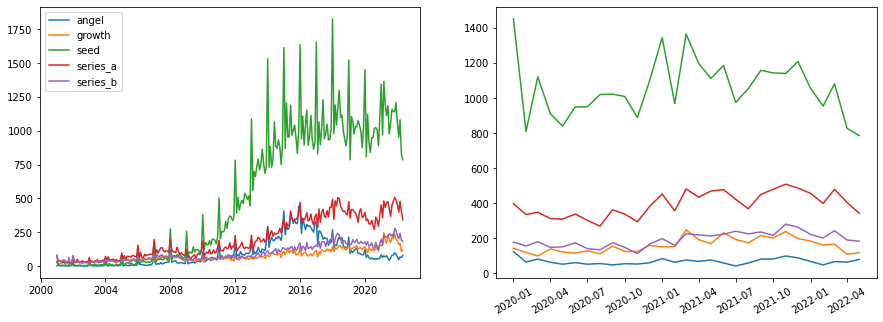

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for tp in rounds_activity.round_type.unique():
    axs[0].plot(rounds_activity[rounds_activity.round_type == tp][['period', 'count']].set_index('period'), label=tp)
axs[0].legend()
for tp in rounds_activity.round_type.unique():
    axs[1].plot(rounds_activity[(rounds_activity.period.dt.year > 2019) & (rounds_activity.round_type == tp)][['period', 'count']].set_index('period'), label=tp)
plt.xticks(rotation=30)
plt.show()

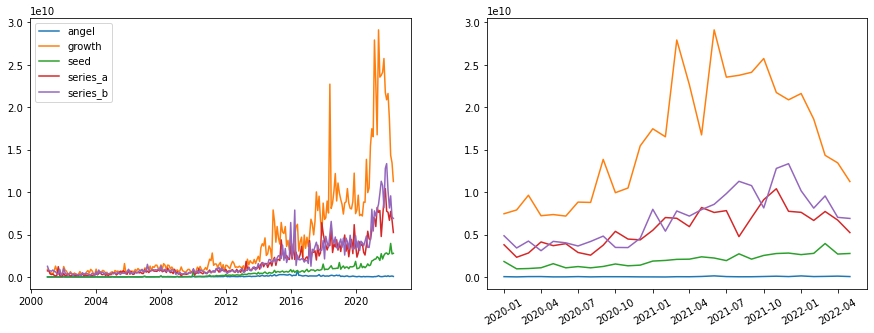

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for tp in rounds_activity.round_type.unique():
    axs[0].plot(rounds_activity[rounds_activity.round_type == tp][['period', 'raised_amount_usd']].set_index('period'), label=tp)
axs[0].legend()
for tp in rounds_activity.round_type.unique():
    axs[1].plot(rounds_activity[(rounds_activity.period.dt.year > 2019) & (rounds_activity.round_type == tp)][['period', 'raised_amount_usd']].set_index('period'), label=tp)
plt.xticks(rotation=30)
plt.show()

<AxesSubplot:ylabel='Count'>

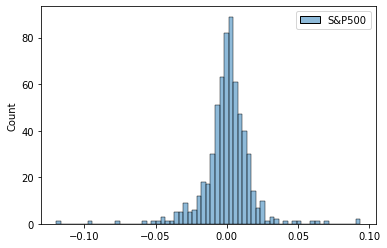

In [ ]:
sp500 = get_yfinance_time_series('^GSPC', start=2020, end=None)
daily_ret = sp500.pct_change()
daily_ret = daily_ret.reset_index()
daily_ret.columns=['date', 'S&P500']
sns.histplot(data=daily_ret)

In [ ]:
ipos = pd.read_csv('../../data/crunchbase/ipos.csv')
acqs = pd.read_csv('../../data/crunchbase/acquisitions.csv')

In [ ]:
prop = orgs.groupby(orgs.status).size() / orgs.shape[0]
prop = prop.map('{:.2%}'.format)
prop

status
acquired      5.49%
closed        6.68%
ipo           2.00%
operating    85.83%
dtype: object

In [ ]:
big_countries = rounds.groupby('country_code').size()
big_countries = big_countries[big_countries > 2000]

df = rounds[rounds.country_code.isin(big_countries.index)]
df.groupby('country_code').mean().post_money_valuation_usd.sort_values().dropna()[-10:]

country_code
GBR     $348,280,808.81
FRA     $470,041,366.54
DEU     $670,430,134.17
USA     $753,133,295.26
SWE     $769,545,585.46
JPN     $801,605,945.59
NLD     $974,746,363.75
IND   $1,470,622,433.54
KOR   $2,637,464,789.95
CHN   $3,752,944,377.85
Name: post_money_valuation_usd, dtype: float64

In [ ]:
df.groupby('meta_cat').mean().post_money_valuation_usd.sort_values().dropna()[-10:].astype(int)

meta_cat
Energy             238690763
IT Hardware        321492178
Healthcare         498840421
Other              657836796
Media              758248357
Consumer P&S       799821843
Software           810884147
Commercial P&S     942134030
Biotech           1119291342
Name: post_money_valuation_usd, dtype: int64

/var/folders/9g/9p32rxp10c37hppq5lydn44c0000gn/T/ipykernel_20790/2238396604.py:1: DtypeWarning:

Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


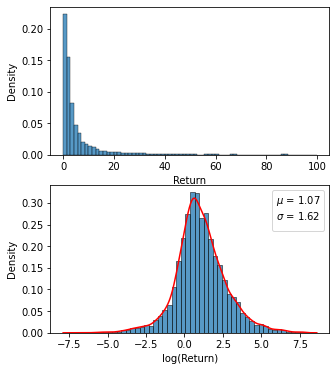

In [ ]:
complete = pd.read_csv('../../data/data.csv')

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5,6))
sns.histplot(complete[complete.return_usd < 100].return_usd, ax=axs[0], bins=70, stat="density")
sns.histplot(np.log(complete.return_usd.dropna()), bins=50, stat="density", ax=axs[1])
sns.kdeplot(np.log(complete.return_usd.dropna()), color="r", ax=axs[1])
axs[0].set_xlabel('Return')
axs[1].set_xlabel('log(Return)')
axs[1].legend(title=f'$\mu$ = {np.log(complete.return_usd.dropna()).mean():.2f}\n$\sigma$ = {np.log(complete.return_usd.dropna()).std():.2f}')
plt.savefig('figures/returns.pdf')

In [ ]:
original = pd.read_csv('../../data/crunchbase/funding_rounds.csv')
print(f'Missing PMVs: {original.post_money_valuation_usd.isna().sum() / original.shape[0] * 100:.2f}% ({original.post_money_valuation_usd.isna().sum()})')
print(f'Available PMVs: {original.post_money_valuation_usd.notna().sum() / original.shape[0] * 100:.2f}% ({original.post_money_valuation_usd.notna().sum()})')

Missing PMVs: 94.56% (462260)
Available PMVs: 5.44% (26601)


In [ ]:
complete

,company_num,group_num,seg_num,round_date,raised_usd,postvalue_usd,exit_date,exit_type,exit_value,return_usd
0,000cff2d-58df-0a9a-97ea-6b73ed9ec601,NaN,NaN,2016-07-21,"$100,000.00","$1,120,240.14",2020-03-06,2,NaN,NaN
1,0012f446-a31b-9eb8-4fa0-448ed0414112,NaN,NaN,2000-03-07,"$14,000,000.00","$70,598,575.43",2005-06-01,3,NaN,NaN
2,00251aad-6e34-0898-8a72-fe8864a90f92,NaN,NaN,2012-10-04,"$650,532.00","$3,238,880.30",2016-11-08,2,NaN,NaN
3,002aac96-79d4-a8f3-8ef0-d44fb240951d,NaN,NaN,2000-05-12,"$3,000,000.00","$11,260,369.05",2006-11-09,2,NaN,NaN
4,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,NaN,NaN,2016-01-11,"$45,000,000.00","$210,429,441.57",2020-12-15,1,"$577,580,000.00",$2.44
...,...,...,...,...,...,...,...,...,...,...
119878,fffe3b0b-8545-4414-9c0e-a3f961c4e420,NaN,NaN,2017-02-07,"$14,523,274.00","$85,258,286.20",NaN,4,NaN,NaN
119879,ffff2bea-7e44-4563-b311-65daadb683cd,NaN,NaN,2010-12-07,"$451,407.00","$2,387,976.17",NaN,4,NaN,NaN
119880,ffff2bea-7e44-4563-b311-65daadb683cd,NaN,NaN,2013-04-25,"$1,616,916.00","$8,092,736.68",NaN,4,NaN,NaN
119881,ffffabce-6d4a-b3d1-13c0-4e90cedf5270,NaN,NaN,2016-05-15,"$210,000.00","$2,649,444.56",NaN,4,NaN,NaN


In [ ]:
rounds['year_added'] = pd.to_datetime(rounds.created_at).dt.year

In [ ]:
s = pd.to_datetime(rounds.created_at)
added_num = s.groupby(s.dt.floor('d')).size()

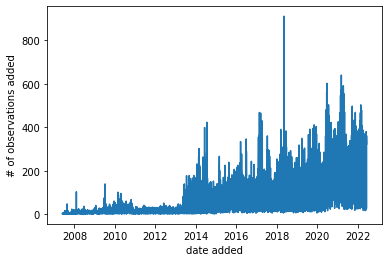

In [ ]:
sns.lineplot(x=added_num.index, y=added_num.values)
plt.xlabel('date added')
plt.ylabel('# of observations added')
plt.savefig('figures/date_added.pdf')

In [ ]:
added_num[added_num.index.year > 2013].mean()

142.94088989931797

In [ ]:
added_num

created_at
2007-05-27      3
2007-05-29      1
2007-05-31      2
2007-06-01      2
2007-06-02      2
             ... 
2022-06-05     26
2022-06-06    283
2022-06-07    361
2022-06-08    344
2022-06-09    323
Name: created_at, Length: 5378, dtype: int64